Experimenting and re-implementing different types of deep learning architecture layers.

In [5]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from utils.plots import linear_plot, plot_histograms

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Batch Normalization (BatchNorm1D / 2D)

Applies Batch Normalization over an input. Batch Normalization is a normalization technique that can be applied at the layer level. Put simply, it **normalizes the inputs to each layer to a learnt representation** likely close to: \\[ \mu = 0.0, \sigma = 1.0 \\] By consequence, all the layer inputs are normalized, and significant outliers are less likely to impact the training process in a negative way. And if they do, their impact will be much lower than without using Batch Normalization. BatchNorm1d is a specific implementation of Batch Normalization in PyTorch, designed for 1-dimensional data. The main idea behind Batch Normalization is to normalize the inputs of each layer in a neural network during training. It **helps us to mitigate the problem of internal covariate shift(the change in the distribution of activations within a neural network as training progresses)**.

* One-dimensional BatchNormalization (nn.BatchNorm1d) applies Batch Normalization over a 2D or 3D input (a batch of 1D inputs with a possible channel dimension).
* Two-dimensional BatchNormalization (nn.BatchNorm2d) applies it over a 4D input (a batch of 2D inputs with a possible channel dimension).

Values sample before: tensor([ 8.6957,  6.3098, 12.1292, 14.8014,  7.4998, 11.2823,  8.3956, 15.3141,
        11.8044, 15.3293]), with max: 23.7570 and min -5.3665
Values sample after: tensor([-0.2881, -0.7377,  0.3110,  0.8437, -0.5830,  0.2800, -0.2946,  0.9363,
         0.2465,  0.9707], grad_fn=<ViewBackward0>), with max: 2.9409 and min -3.1236


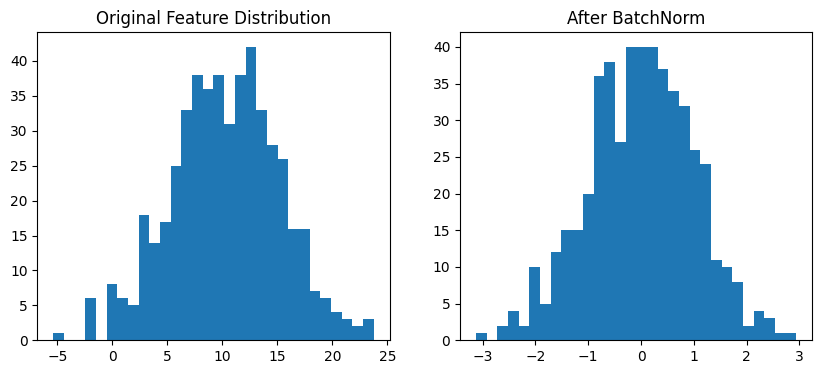

In [38]:
x = torch.randn(100, 5) * 5 + 10
bn = nn.BatchNorm1d(5)
x_bn = bn(x)

print(f"Values sample before: {x[:2].flatten()}, with max: {x.max():.4f} and min {x.min():.4f}")
print(f"Values sample after: {x_bn[:2].flatten()}, with max: {x_bn.max():.4f} and min {x_bn.min():.4f}")

# Plot before and after
plot_histograms(
    [
        {
            "name": "Original Feature Distribution", 
            "values": x.numpy().flatten(),
        },
        {
            "name": "After BatchNorm",
            "values": x_bn.detach().numpy().flatten(),
        }
    ]
)